<a href="https://colab.research.google.com/github/darshil0805/models-from-scratch/blob/main/ShallowNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training shallow neural networks from scratch

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(download = True,train = True,transform = ToTensor(),root = 'data/')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

image.shape: torch.Size([1, 28, 28])
Label: 5


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


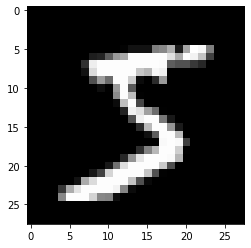

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.resize(28,28), cmap='gray')
print('Label:', label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size=128


In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


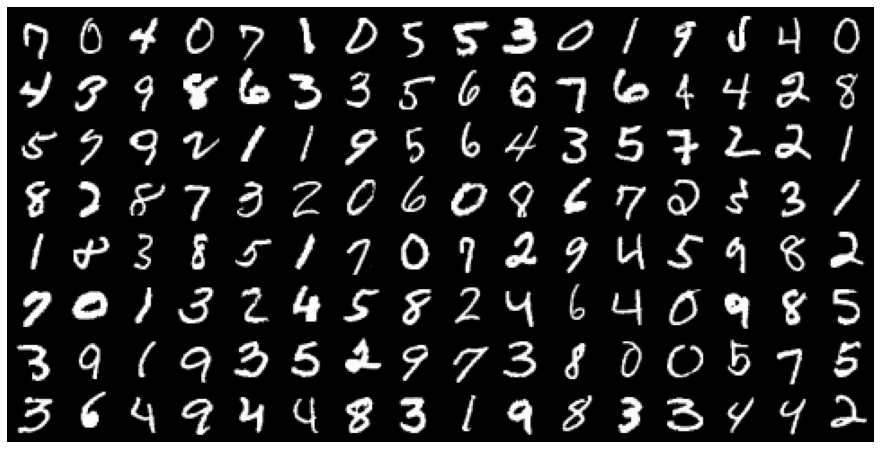

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
def accuracy(output,yb):
  _,preds = torch.max(output,dim = 1)
  return torch.tensor(torch.sum(preds==yb).item())/len(output)

In [10]:
class MnistModel(nn.Module):

  def __init__(self,in_size,hidden_size,output_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size,hidden_size)
    self.relu = F.relu
    self.linear2 = nn.Linear(hidden_size,output_size)

  def forward(self,xb):
    xb = xb.reshape(-1,784)
    out = self.linear1(xb)
    out = self.relu(out)
    out = self.linear2(out)
    return out
  
  def training_step(self,batch):
    xb,yb = batch
    out = self(xb)
    loss = F.cross_entropy(out,yb)
    return loss

  def validation_step(self,batch):
    xb,yb = batch
    out = self(xb)
    loss = F.cross_entropy(out,yb)
    acc = accuracy(out, yb)           
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self,output):
    stacked_loss = torch.stack([x['val_loss'] for x in output])
    val_loss = stacked_loss.mean()
    stacked_acc = torch.stack([x['val_acc'] for x in output])
    val_acc = stacked_acc.mean()
    return {'val_loss':val_loss.item(),'val_acc':val_acc.item()}

  def epoch_end(self,epoch,result):
    print(f"Epoch : {epoch} , Loss : {result['val_loss']} , Accuracy : {result['val_acc']}")


In [11]:
model = MnistModel(784,64,10)

In [12]:
torch.cuda.is_available()

True

In [13]:
def current_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  return torch.device('cpu')

In [14]:
device = current_device()

In [15]:
device

device(type='cuda')

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
class DeviceDataLoader():
  '''Wrap a dataloader to move it to a device '''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch,self.device)

  def __len__(self):
    return len(self.dl)

In [18]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

In [19]:
model = to_device(MnistModel(in_size = 28*28, hidden_size = 64,output_size = 10),device)


In [20]:
next(model.parameters()).is_cuda

True

In [21]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history  = [evaluate(model,val_loader)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
history

[{'val_acc': 0.07607422024011612, 'val_loss': 2.313807487487793}]

In [24]:
history += fit(5,0.5,model,train_loader,val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : 0 , Loss : 0.20532622933387756 , Accuracy : 0.93896484375
Epoch : 1 , Loss : 0.14967525005340576 , Accuracy : 0.954296886920929
Epoch : 2 , Loss : 0.1354159563779831 , Accuracy : 0.9560546875
Epoch : 3 , Loss : 0.12098965793848038 , Accuracy : 0.96435546875
Epoch : 4 , Loss : 0.104736328125 , Accuracy : 0.9678710699081421


In [25]:
history += fit(5,0.1,model,train_loader,val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : 0 , Loss : 0.09610703587532043 , Accuracy : 0.970019519329071
Epoch : 1 , Loss : 0.09527403116226196 , Accuracy : 0.969921886920929
Epoch : 2 , Loss : 0.09346277266740799 , Accuracy : 0.9696289300918579
Epoch : 3 , Loss : 0.09291280806064606 , Accuracy : 0.9703124761581421
Epoch : 4 , Loss : 0.09278329461812973 , Accuracy : 0.970507800579071


In [26]:
history

[{'val_acc': 0.07607422024011612, 'val_loss': 2.313807487487793},
 {'val_acc': 0.93896484375, 'val_loss': 0.20532622933387756},
 {'val_acc': 0.954296886920929, 'val_loss': 0.14967525005340576},
 {'val_acc': 0.9560546875, 'val_loss': 0.1354159563779831},
 {'val_acc': 0.96435546875, 'val_loss': 0.12098965793848038},
 {'val_acc': 0.9678710699081421, 'val_loss': 0.104736328125},
 {'val_acc': 0.970019519329071, 'val_loss': 0.09610703587532043},
 {'val_acc': 0.969921886920929, 'val_loss': 0.09527403116226196},
 {'val_acc': 0.9696289300918579, 'val_loss': 0.09346277266740799},
 {'val_acc': 0.9703124761581421, 'val_loss': 0.09291280806064606},
 {'val_acc': 0.970507800579071, 'val_loss': 0.09278329461812973}]

Text(0.5, 1.0, 'Loss vs No. of epochs')

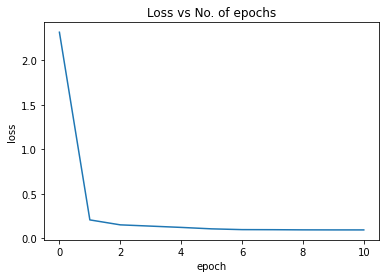

In [27]:
losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

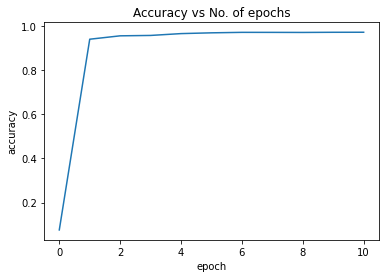

In [28]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

In [29]:
test_dataset = MNIST(download = True,train = False,transform = ToTensor(),root = 'data/')

In [30]:
img, label = test_dataset[0]
print(img.shape)
#img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [31]:
def predict_img(img,model):
  xb = to_device(img,device)
  probs = model(xb)
  _,preds = torch.max(probs,dim = 1)
  return preds[0].item()

Label: 7 Prediction: 7


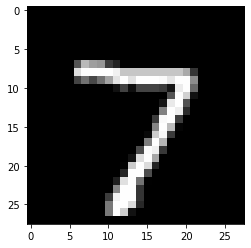

In [32]:
img,label = test_dataset[0]
plt.imshow(img[0],cmap = 'gray')
preds = predict_img(img,model)
print('Label: '+ str(label) + " Prediction: "+ str(preds) )

Label: 6 Prediction: 6


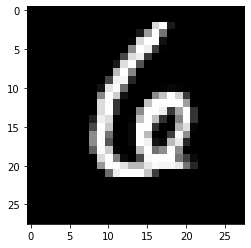

In [33]:
img,label = test_dataset[123]
plt.imshow(img[0],cmap = 'gray')
preds = predict_img(img,model)
print('Label: '+ str(label) + " Prediction: "+ str(preds) )

Label: 5 Prediction: 5


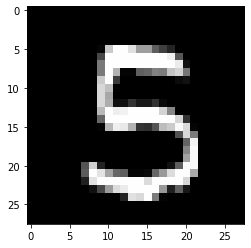

In [34]:
img,label = test_dataset[187]
plt.imshow(img[0],cmap = 'gray')
preds = predict_img(img,model)
print('Label: '+ str(label) + " Prediction: "+ str(preds) )

In [35]:
test_loader = DeviceDataLoader(DataLoader(test_dataset,batch_size = 256),device)
result = evaluate(model,test_loader)

In [37]:
print(result)

{'val_loss': 0.08170052617788315, 'val_acc': 0.9756835699081421}
